# Multi-Channel Model for MobileNet_v2

In [25]:
#Imports necessary for all tasks in this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from random import randint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load images and convert them to an array

Here we hardcoded the path (for the moment) to the local image repository (they have been unziped by hand, Antoina should have a o code for it). We load the images and convert them to an np.array as well as the filename of the images into a list (image_files). The number of images and the length of the image_files needs to be the same! We **don't** normalize the images to 8-bit.

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

base_dir = '/Users/thorsten/code/ThorstenCodes/MorphoMind/raw_data'
plate = '24277'
channels = ['Hoechst', 'Ph_golgi', 'ERSytoBleed', 'ERSyto', 'Mito']

images = []
image_files = []  # Initialize outside the loop to collect all paths

# Loop through each channel and process images
for channel in channels:
    channel_dir = os.path.join(base_dir, f"plate_{plate}", f"{plate}-{channel}")
    if os.path.isdir(channel_dir):
        files = [os.path.join(channel_dir, f) for f in os.listdir(channel_dir) if f.lower().endswith('.tif')]
        image_files.extend(files)  # Append new files to the list
        for img_path in files:
            img = load_img(img_path, target_size=(224, 224))
            img = img_to_array(img)
            images.append(img)
    else:
        print(f"Directory {channel_dir} not found.")

images = np.array(images)
print(f"Length of image_files: {len(image_files)}")
print(f"Loaded {len(images)} images.")

Length of image_files: 11520
Loaded 11520 images.


In [6]:
images.shape

(11520, 224, 224, 3)

In [7]:
images

array([[[[152., 152., 152.],
         [145., 145., 145.],
         [143., 143., 143.],
         ...,
         [165., 165., 165.],
         [169., 169., 169.],
         [157., 157., 157.]],

        [[152., 152., 152.],
         [151., 151., 151.],
         [145., 145., 145.],
         ...,
         [158., 158., 158.],
         [166., 166., 166.],
         [159., 159., 159.]],

        [[140., 140., 140.],
         [146., 146., 146.],
         [141., 141., 141.],
         ...,
         [156., 156., 156.],
         [151., 151., 151.],
         [154., 154., 154.]],

        ...,

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
       

# Model (Preprocessing and predicting)

In [8]:
import tensorflow as tf
from tensorflow import keras

def build_feature_extractor(img_width=224, img_height=224, pretrained_model='MobileNetV2'):
    ''' This functions loads the top-layer of the model and extracts its preprocessing and applies it to the images'''
    # Correctly initialize models and preprocessing functions
    models = {'MobileNetV2': tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(img_height, img_width, 3))}
    preprocess = {'MobileNetV2': keras.applications.mobilenet_v2.preprocess_input}

    feature_extractor = models[pretrained_model]
    preprocess_input = preprocess[pretrained_model]

    inputs = keras.Input((img_height, img_width, 3))
    preprocessed = preprocess_input(inputs)
    outputs = feature_extractor(preprocessed)

    return keras.Model(inputs, outputs, name="feature_extractor")

In [10]:
# Instantiate the feature extractor model
feature_extractor_model = build_feature_extractor()

In [11]:
# Extract features by using MobileNetv2 weights
features = feature_extractor_model.predict(images)

360/360 [==============================] - 80s 219ms/step


In [12]:
type(features)

numpy.ndarray

# Dimensionality Reduction by PCA and Clustering by KMeans

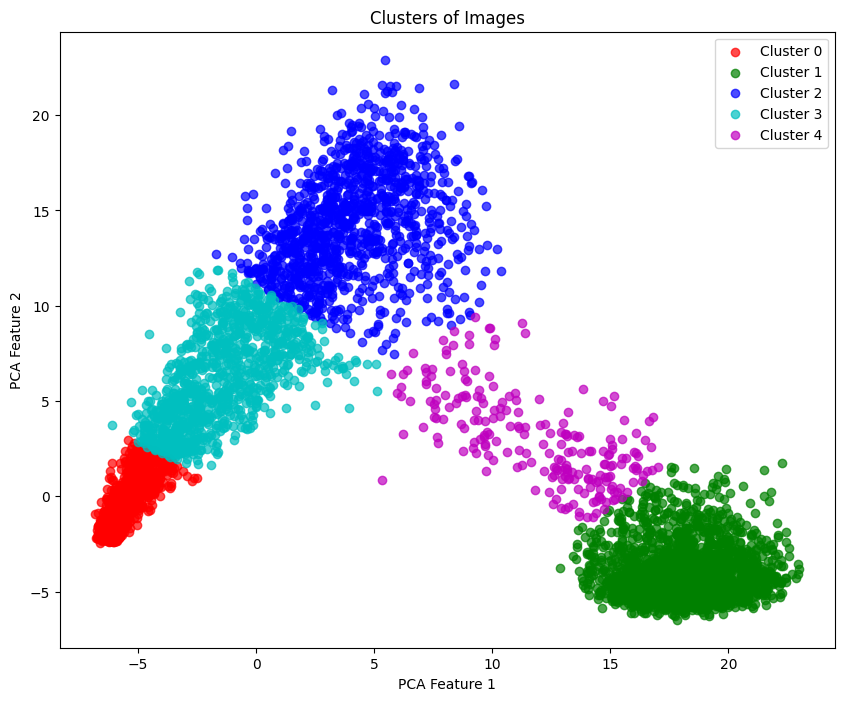

In [29]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

##################################
###### PCA ######################
#################################

# Number of components for PCA
n_components = 2

# Initialize and fit PCA
pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(features)

#################################
### Clustering using Kmeans #####
#################################

# Number of clusters
n_clusters = 5

# Initialize KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit KMeans on the features
clusters = kmeans.fit_predict(reduced_features)

cluster_labels = kmeans.labels_

########################
###### Plotting ########
########################

plt.figure(figsize=(10, 8))

# Color map for clusters
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i in range(n_clusters):
    plt.scatter(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.7, color=colors[i % len(colors)])

plt.title('Clusters of Images')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.show()


In [28]:
reduced_features

array([[20.916187 , -4.841809 ],
       [20.432413 , -3.677938 ],
       [17.348108 , -4.7825255],
       ...,
       [-6.136095 , -2.3016992],
       [-6.1363072, -2.3013165],
       [-6.1363072, -2.3013165]], dtype=float32)

In [19]:
print(cluster_labels)
reduced_features

[2 1 2 ... 0 0 0]


array([[20.91801  , -4.836983 ],
       [20.434046 , -3.6777644],
       [17.349443 , -4.7823486],
       ...,
       [-6.1365767, -2.301597 ],
       [-6.1367917, -2.301214 ],
       [-6.1367917, -2.301214 ]], dtype=float32)

# Plotting example pictures from each Cluster

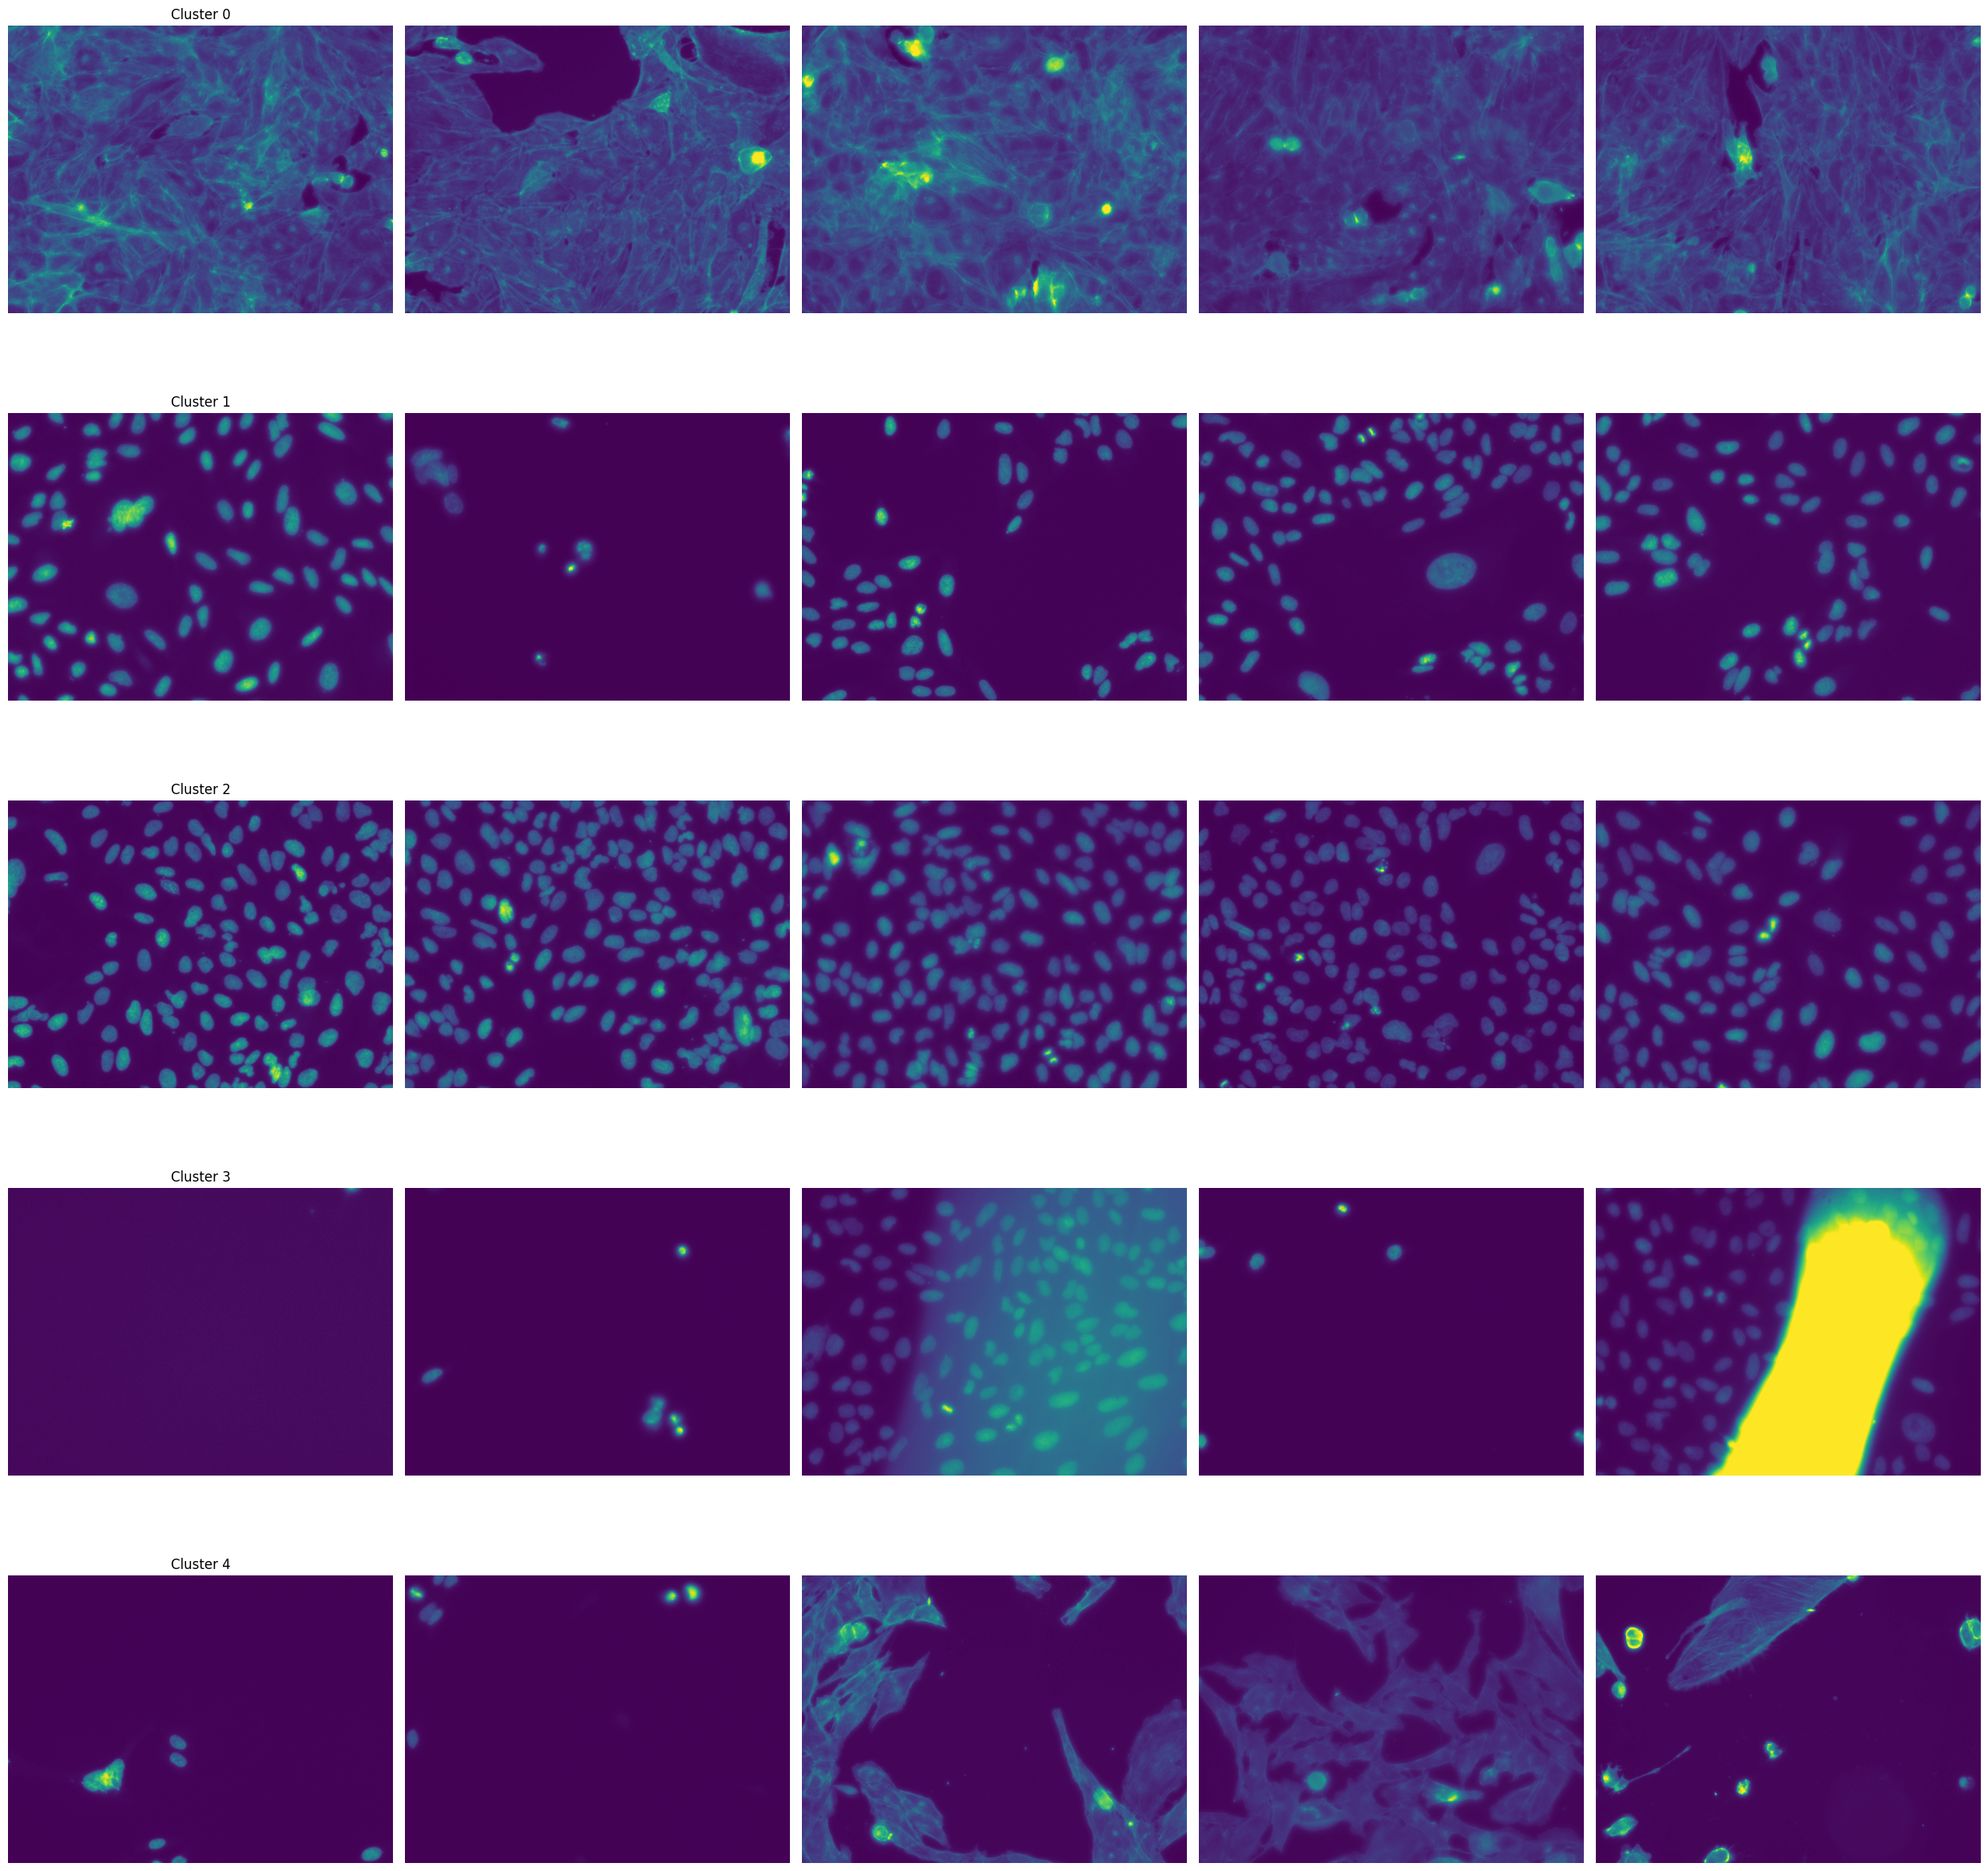

In [24]:
from PIL import Image
images_per_cluster = 5
n_clusters=5
# Create subplots - rows are clusters, columns are images
fig, axs = plt.subplots(n_clusters, images_per_cluster, figsize=(5 * images_per_cluster, 5 * n_clusters))
for i in range(n_clusters):
    # Get indices of images in this cluster
    indices = np.where(clusters == i)[0]
    # Select a subset of images from the cluster
    selected_indices = indices[:images_per_cluster]  # Take the first ‘n’ images for simplicity
    for j, idx in enumerate(selected_indices):
        # Load and display the image
        img_path = image_files[idx]  # Assuming ‘image_files’ contains paths of images in the same order as ‘features’
        img = Image.open(img_path)
        ax = axs[i, j] if n_clusters > 1 else axs[j]
        ax.imshow(np.asarray(img))
        ax.axis('off')  # Hide the axis
        if j == 0:
            ax.set_title(f'Cluster {i}')
# Adjust layout
plt.tight_layout()
plt.show()